# Boundary reflection by conditional probability.

In the file, we are not longer using simple reflection algorithm. Instead, we save the particle's postion Z_n, and then one time increment of SDE scheme on these particles, then we get Z_{n+1}. If Z_{n+1} is outside the boundary, We throw away the Z_{n+1} and compute it one more time until it is inside the boundary. Idea is to ulltilise central limit theorem to achieve conditional probability in wiener process. 

* The best way to direction change normal distribution to conditional normal distribution. But it takes time to code. En easy way to verify the idea is, by central limit theorem, if I have enoungh particles, we will achieve conditional normal distribution when we reject impossible event such z<0, z>H. 

In [1]:
import numpy as np
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
%matplotlib inline
plt.style.use('bmh')

## Diffusivity profile

In [2]:
import sympy
#sympy.init_printing()

z = sympy.symbols('z')

K0 = 1e-3# m * * 2 / s
#K0 = 0
K1 = 5e-3# m / s
Aalpha = 0.5
c=20
w=0

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)


## Lgrangian schemes

In [3]:
#######
#Euler#
#######
def step_e(z,H,dt,N_sample):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=dKdz(z)
    b=np.sqrt(2*Diffu(z))
    temp=z+a*dt+b*dW
    return temp

def step_e_const(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    K0=3e-3
    b=np.sqrt(2*K0)
    
    temp=z+b*dW
    return temp

########
#Visser#
########
def step_v(z,H,dt,N_sample):
    
    #Original
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3
    
    #Wiener process
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    r=dt
    
    a=dKdz(z)
    G=Diffu(z+a*dt/2)
    
    temp= z + a*dt + np.sqrt(2/r*dt*G)*dW
    return temp

def step_v_const(z,H,dt,N_sample):
    K0=3e-3
    
    #Original
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3
    
    #Wiener process
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    r=dt
    
    temp= z + np.sqrt(2/r*dt*K0)*dW
    return temp

##############
#Milstein 1nd#
##############
def step_m(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    temp= z + (1/2)*dKdz(z)*(dW*dW+dt) + Beta(z)*dW
    return temp

##############
#Milstein 2nd#
##############
def step_m2(z,H,dt,N_sample):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    k=Diffu(z)
    dkdz=dKdz(z)
    ddkdz=dAdz(z)
    dddkdz=ddAdzz(z)
    sqrt2k=np.sqrt(2*k)
    
    a=dkdz
    da=ddkdz
    dda=dddkdz
    b= sqrt2k 
    db=dkdz/b
    ddb=ddkdz/b - ((dkdz)**2)/b**3
    ab=da*b+a*db
    
    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2
    
    return temp

def step_m2_const(z,H,dt,N_sample):
    K0=3e-3
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    temp= z +np.sqrt(2*K0)*dW
    return temp

# The key is here.

In [4]:
def oneStep(Z, scheme,H, dt):
    
    z_Origin = Z.copy()
    
    Z = scheme(Z, H, dt, Z.size)
    
    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    
    #The key is here, It act like a conditional probability such you can not have particle outside the boudnary.
    #maskOutSide = ((H < Z) | (0 > Z))
    #
    #
    #
    #if (np.any(maskOutSide)):
    #    loop = True
    #else:
    #    loop = False
    #
    #while (loop):
    #    somes = z_Origin[maskOutSide]
    #    somes = scheme(somes, H, dt, somes.size)
    #    Z[maskOutSide] = somes
    #    temp_mask = ((H < somes) | (0 > somes))
    #    maskOutSide[maskOutSide] = temp_mask
    #    
    #    if (np.any(temp_mask) == False):
    #        loop = False
            
    return Z

## Parallel functions

In [5]:
def parallelWiener(Tmax, dt, H, Testdepth, Np, Nbins,
                     queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const):
    np.random.seed()
    Ntime   =int(Tmax/dt)  

    hist_E      =np.zeros((Nbins-1,),'i')
    hist_V      =np.zeros((Nbins-1,),'i')
    hist_M      =np.zeros((Nbins-1,),'i')
    hist_M2     =np.zeros((Nbins-1,),'i')
    hist_EConst =np.zeros((Nbins-1,),'i')
    hist_VConst =np.zeros((Nbins-1,),'i')
    hist_MConst =np.zeros((Nbins-1,),'i')

    #zEul    =np.random.uniform(0,H,int(Np))
    #zVis    =np.random.uniform(0,H,int(Np))
    #zMil    =np.random.uniform(0,H,int(Np))
    #zMil2   =np.random.uniform(0,H,int(Np))
    #zEulCon =np.random.uniform(0,H,int(Np))
    #zVisCon =np.random.uniform(0,H,int(Np))
    #zMilCon =np.random.uniform(0,H,int(Np))

    
    for i in range(Ntime):
        
        
        zMil = np.linspace(0,H,int(Np)+2)
        #zMil = np.delete(zMil,0)
        #zMil = np.delete(zMil,-1)
        
        #zEul = oneStep( zEul,    step_e,         H, dt)
        #zVis = oneStep( zVis,    step_v,         H, dt)
        zMil = oneStep( zMil,    step_m,         H, dt)
        #zMil2 = oneStep( zMil2,   step_m2,        H, dt)
        #zEulCon = oneStep( zEulCon, step_e_const,   H, dt)
        #zVisCon = oneStep( zVisCon, step_v_const,   H, dt)
        #zMilCon = oneStep( zMilCon, step_m2_const,  H, dt)

        #Adding the histogram
        ###
        #temp0, _ = np.histogram(zEul, bins = np.linspace(0, Testdepth, Nbins))
        #hist_E=hist_E + temp0
#
        #temp1, _ = np.histogram(zVis, bins = np.linspace(0, Testdepth, Nbins))
        #hist_V=hist_V + temp1
#
        temp2, _ = np.histogram(zMil, bins = np.linspace(-Testdepth, Testdepth, Nbins))
        hist_M=hist_M + temp2
#
        #temp3, _ = np.histogram(zMil2, bins = np.linspace(0, Testdepth, Nbins))
        #hist_M2=hist_M2 + temp3
#
        #### Constant potensial
        #temp4, _ = np.histogram(zEulCon, bins = np.linspace(0, Testdepth, Nbins))
        #hist_EConst=hist_EConst + temp4
#
        #temp5, _ = np.histogram(zVisCon, bins = np.linspace(0, Testdepth, Nbins))
        #hist_VConst=hist_VConst + temp5
#
        #temp6, _ = np.histogram(zMilCon, bins = np.linspace(0, Testdepth, Nbins))
        #hist_MConst=hist_MConst + temp6

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    queneEu.put(hist_E)
    queneEuConst.put(hist_EConst)
    queneV.put(hist_V)
    queneVConst.put(hist_VConst)
    queneM.put(hist_M)
    queneM2.put(hist_M2)
    queneM2Const.put(hist_MConst)
    return None
        
def RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter=Ntime

    if (__name__ == '__main__'):
        threads=[]
        queneEu=      mp.Queue()
        queneEuConst= mp.Queue()
        queneV=       mp.Queue()
        queneVConst=  mp.Queue()
        queneM=       mp.Queue()
        queneM2=      mp.Queue()
        queneM2Const= mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallelWiener, 
                                args= (Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                       queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const))
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_E      = np.zeros((Nbins-1,),'i')
    hist_EConst = np.zeros((Nbins-1,),'i')
    hist_V      = np.zeros((Nbins-1,),'i')
    hist_VConst = np.zeros((Nbins-1,),'i')
    hist_M      = np.zeros((Nbins-1,),'i')
    hist_M2     = np.zeros((Nbins-1,),'i')
    hist_MConst = np.zeros((Nbins-1,),'i')
    

    for i in range(NumberOfThread):
        hist_E      += queneEu.get()
        hist_EConst += queneEuConst.get()
        hist_V      += queneV.get()
        hist_VConst += queneVConst.get()
        hist_M      += queneM.get()
        hist_M2     += queneM2.get()
        hist_MConst += queneM2Const.get()

    #hist_E  = hist_E  / counter
    #hist_V  = hist_V  / counter
    #hist_M  = hist_M  / counter
    #hist_M2 = hist_M2 / counter
    #hist_EConst = hist_EConst / counter
    #hist_VConst = hist_VConst / counter
    #hist_MConst = hist_MConst / counter

    #hist_E  = hist_E  / np.mean(hist_E)
    #hist_V  = hist_V  / np.mean(hist_V)
    #hist_M  = hist_M  / np.mean(hist_M)
    #hist_M2 = hist_M2 / np.mean(hist_M2)
    #hist_EConst  = hist_EConst / np.mean(hist_EConst)
    #hist_VConst  = hist_VConst / np.mean(hist_VConst)
    #hist_MConst  = hist_MConst / np.mean(hist_MConst)
    
    lists=[]
    lists.append(hist_E)
    lists.append(hist_V)
    lists.append(hist_M)
    lists.append(hist_M2)
    lists.append(hist_EConst)
    lists.append(hist_VConst)
    lists.append(hist_MConst)
    
    return lists

In [6]:
# Criterion checking

z=np.linspace(0, 10,1000)
profile=dAdz(z)
Maxdt=(1/np.max(np.abs(profile)))
print(Maxdt)

200.0


## Conditional probability method by rejection of Wiener process. 

In [7]:
test = np.linspace(0, 10, 4002)

test = np.delete(test,0)
test = np.delete(test,-1)
print(len(test))

4000


In [8]:
Np        = 4000000
Nbins     = 200
Tmax      = 1000          #Maximum time
dt        = 2             #Delta time
H         = 10
Testdepth = 0.000001
NumberOfThread = 4

startTime=time()
lists = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins)
endTime=time()
print("Time elapsed: ", endTime-startTime)

hist_E      = lists[0]
hist_V      = lists[1]
hist_M      = lists[2]
hist_M2     = lists[3]
hist_EConst = lists[4]
hist_VConst = lists[5]
hist_MConst = lists[6]

#hist_M = hist_M/ np.sum(hist_M)

Total number of process:  4


Process Process-2:
Process Process-4:
Process Process-1:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mhyip/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mhyip/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mhyip/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-5-ed20036c7913>", line 32, in parallelWiener
    zMil = oneStep( zMil,    step_m,         H, dt)
  File "/home/mhyip/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mhyip/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mhyip/anaconda3/lib/python3.6/multiprocessing/process.py", line 93,

KeyboardInterrupt: 

In [ ]:
bins = np.linspace(-Testdepth, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27), sharey = True, sharex = True)
#fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27))
#ax[0].plot(hist_E, midpoints, linewidth=1.5, label= "variable")
#ax[0].plot(hist_EConst, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('Euler-Maruyama')
ax[0].invert_yaxis()
ax[0].legend()

#ax[1].plot(hist_V, midpoints, linewidth=1.5, label= "variable")
#ax[1].plot(hist_VConst, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concetration')
ax[1].set_title('Visser')
ax[1].legend()


ax[2].plot(hist_M, midpoints, linewidth=1.5, label= "variable")
#ax[2].plot(hist_MConst, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concetration')
ax[2].set_title('Milstein 1 st')
ax[2].legend()

#ax[3].plot(hist_M2, midpoints, linewidth=1.5, label= "variable")
#ax[3].plot(hist_MConst, midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concetration')
ax[3].set_title('Milstein 2 nd')
#ax[3].set_xlim(0.8, 1.2)
ax[3].legend()

plt.tight_layout()
#plt.savefig("To_Tor1.png")

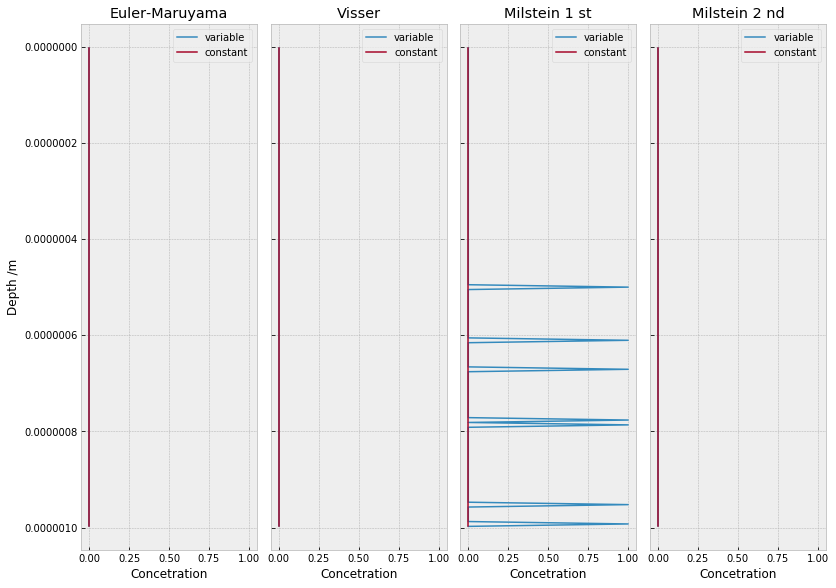

In [57]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27), sharey = True, sharex = True)
#fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27))
ax[0].plot(hist_E, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(hist_EConst, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('Euler-Maruyama')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(hist_V, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(hist_VConst, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concetration')
ax[1].set_title('Visser')
ax[1].legend()


ax[2].plot(hist_M, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(hist_MConst, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concetration')
ax[2].set_title('Milstein 1 st')
ax[2].legend()

ax[3].plot(hist_M2, midpoints, linewidth=1.5, label= "variable")
ax[3].plot(hist_MConst, midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concetration')
ax[3].set_title('Milstein 2 nd')
#ax[3].set_xlim(0.8, 1.2)
ax[3].legend()

plt.tight_layout()
#plt.savefig("To_Tor1.png")